In [29]:
import shelve
import io
#import gdbm
#mod = __import__('gdbm')
#import dumbdbm
import pandas as pd
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import datasets, decomposition
import numpy as np
import gc
from datetime import datetime
import datetime as dt
#datetime.strptime('2016-03-29','%Y-%d-%m')
import dateparser
from ipykernel import kernelapp as app
import csv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from operator import itemgetter
import folium
from folium.plugins import HeatMap
import Instalib_py3 as IL
import Instaplot_py3 as IP
import math
import re
import string
import emoji
import pickle
import scipy.io
from sklearn.feature_extraction.text import CountVectorizer
import nltk.stem
import sktensor
import geopy.distance
from itertools import groupby
import ncp_py3
from datetime import timedelta
from dateutil.relativedelta import *
import os
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
import nltk.data #
nltk.download('punkt')
from nltk.stem.snowball import FrenchStemmer
italian_stemmer = nltk.stem.SnowballStemmer('italian')
english_stemmer = nltk.stem.SnowballStemmer('english')
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
import langid
langid.set_languages(['it', 'en'])  # ISO 639-1 codes
import importlib


[nltk_data] Downloading package punkt to /home/eartiges/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Open the file and have a first look

Read the data and concatenate in a single DataFrame file, basic file format for pandas. It's a 2-D object, tabular file with labeled rows and columns, built from a dictionary or such. 

More info about it here: https://pandas.pydata.org/pandas-docs/stable/10min.html

Make our life easier by matching the Torino labels with the Marseille ones and convert strings to datetime

In [19]:
df_users_list=[d for d in os.listdir('USERS') if 'dataframe' in d]

df_new=pd.read_pickle('USERS/'+df_users_list[0])
#df_new=df_new.rename(columns = {'caption':'text','taken_at_timestamp':'date'})
df_new.head()

for df in df_users_list:
    df_new=pd.concat([df_new,pd.read_pickle('USERS/'+df)])

user_loc_dict=pickle.load(open('user_loc_dict.pkl','rb'))

df_new['user_loc']=df_new['user_id'].apply(lambda x : max(user_loc_dict[x],key=itemgetter(1))[0])

def to_coords(user_loc):
    if 'km' in user_loc:
        user_loc=[float(i) for i in user_loc.split(',')[0:2]]
        return user_loc
    else:
        return [float(i) for i in user_loc[1:-1].split(',')]

df_new['user_loc']=df_new['user_loc'].apply(to_coords)

In [28]:
df_new.groupby('lang').count().text.sort_values()

lang
bo          1
ur          1
kn          2
sr          4
th          5
bg          9
el         11
vi         46
fa         58
is         75
zh         85
hu         87
hi         88
ar        102
sl        123
sv        146
ko        162
ja        184
lv        188
fi        214
tr        218
cs        221
cy        221
no        249
uk        259
da        305
pl        346
eu        458
lt        515
et        527
nl        528
ro        595
ca       1106
ht       1262
de       1381
tl       1704
ru       2189
in       4148
fr       5256
pt       7857
es      18849
und     34333
en      96004
it     313808
Name: text, dtype: int64

In [385]:
df_new.rename(columns={'created_at':'date', 'location':'loc_field','user_loc':'coords'},inplace=True)
df_new.set_index('user_id',inplace=True)

In [387]:
importlib.reload(IL)
list_dates, Histo = IL.N_posts(df_new, debug=False)
Npostslog=[np.log10(H) for H in Histo]
Nposts=[H for H in Histo]

[nltk_data] Downloading package punkt to /home/eartiges/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


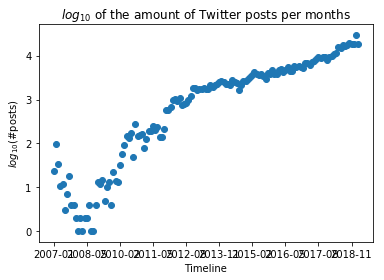

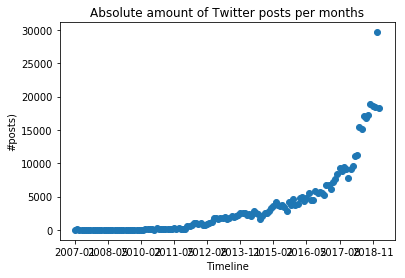

In [388]:
if 'Figures' not in os.listdir('.') and False:
    os.mkdir('Figures')
    os.mkdir('Figures/Shape')
    os.mkdir('Figures/Shape/Spatial')
    os.mkdir('Figures/Shape/Temporal')
plt.figure()
plt.scatter(list_dates, Npostslog)
plt.xticks(list_dates[0::15])
plt.ylabel(r'$log_{10}$(#posts)')
plt.xlabel('Timeline')
plt.title(r'$log_{10}$ of the amount of Twitter posts per months')
#plt.savefig('Figures/Shape/Temporal/Torino_logN.pdf')
plt.show()
plt.figure()
plt.scatter(list_dates, Nposts)
plt.xticks(list_dates[0::15])
plt.ylabel('#posts)')
plt.xlabel('Timeline')
plt.title('Absolute amount of Twitter posts per months')
#plt.savefig('Figures/Shape/Temporal/Torino_N.pdf')
plt.show()

In [389]:
TbyCoords=[e for e in zip(df_new.date,df_new.coords)]

In [390]:
TbyCoords[0][0]

Timestamp('2019-02-13 23:26:08+0000', tz='UTC')

In [391]:
#Heatmap per year
for year in range(2007,2019,1):
    Coordinates=[]
    for t in TbyCoords:
        if str(t[0])[0:4]==str(year):
            Coordinates.append(t[1])
    IL.geo_heatmap(Coordinates ,Nposts, save=False,filename='hm'+str(year),)

KeyboardInterrupt: 

# Let's refine the DataFrame

In [392]:
pickle.dump(df_new, open('df_new_chkpt1.pkl', 'wb'))

Build the frame and the grid. $$x_{min/max}=longitude_{min/max}$$ and conversely for y and latitude.

In [393]:
df_new['lat']=[e[0] for e in df_new['coords']]
df_new['lon']=[e[1] for e in df_new['coords']]

In [394]:

# Attention problème d'arrondi lors du passage de Coord à (lat,lon)
step_m=0.5
lat1,lat2,step_lat,lon1,lon2,step_lon,to_bin_lon,to_bin_lat = IL.build_grid(df_new,step_m)
number_lats,number_lon,df_new=IL.add_grid_todf(df_new,to_bin_lat,to_bin_lon,step_lat,step_lon)
print (number_lats, number_lon)
df_new.coords=df_new.coords.apply(tuple)

28.000000000001027 25.000000000000025


### Checkpoint 2

In [396]:
#pickle.dump(df_new, open('df_new_chkpt2.pkl', 'wb'))
#df_new=pd.read_pickle('df_new_chkpt2.pkl')

# Time to clean the text

But first make a copy before we do anything stupid

In [136]:
df_new_save=df_new.copy()
#df_new=df_new_save.copy()

This methods works only on unicode text. So we need to use the function x.decode('utf-8') to convert all strings in the 'text' field to unicode objects.

In [398]:
text_0=df_new.text.tolist()[8]
print(text_0)

Tieni duro 😘😘😘 https://t.co/ReRDzOebyR


In [399]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
#df_new['text_new2'] = df_new['text_new2'].map(lambda x: emoji_pattern.sub(r'', x))
       
#It works on unicode but not on a string:
    
text = u'This dog \U0001f602'
print(text) # with emoji
print(emoji_pattern.sub(r'', text)) # no emoji

text = 'This dog \U0001f602'
print(text) # with emoji
print(emoji_pattern.sub(r'', text)) # no emoji

print('\n but some emojis still pass through... \n')

text=text_0
print(text) # with emoji
print(emoji_pattern.sub(r'', text)) # no emoji

print(text) # with emoji
print(emoji_pattern.sub(r'', text)) # no emoji


This dog 😂
This dog 
This dog 😂
This dog 

 but some emojis still pass through... 

Tieni duro 😘😘😘 https://t.co/ReRDzOebyR
Tieni duro  https://t.co/ReRDzOebyR
Tieni duro 😘😘😘 https://t.co/ReRDzOebyR
Tieni duro  https://t.co/ReRDzOebyR


Another way to deal with emoji would be to de-emojize them. They would then count as words, that can either be removed
since they have the very peculiar following form :grinning_face: 

The difficulty here is identifying emojis in a text. Their classification is hard to decypher

In [400]:
print(text) # with emoji
print(emoji.demojize(text)) # no emoji

Tieni duro 😘😘😘 https://t.co/ReRDzOebyR
Tieni duro :face_blowing_a_kiss::face_blowing_a_kiss::face_blowing_a_kiss: https://t.co/ReRDzOebyR


In [330]:
#df_new=pd.read_pickle('df_new_chkpt2.pkl')

In [402]:
#importlib.reload(IL)
df_new=IL.text_processing(df_new)
df_new.drop(['text'],axis=1,inplace=True)
df_new=df_new.rename(columns = {'text_new':'text'})
df_new.text=[e.decode('utf-8') for e in df_new.text.tolist()]
df_new['coordsbin'] = list(zip(df_new.latbin,df_new.lonbin))
#print len(df_new_save.text.tolist()) - len(df_new.text.tolist()), 'posts deleted in the process'
df_new.head()

,rt,date,lang,loc_field,coords,lat,lon,latbin,lonbin,text,coordsbin
user_id,,,,,,,,,,,
17043150,True,2019-02-13 23:26:08+00:00,en,"Torino, Italy*user","(45.071999999999996, 7.672035750244399)",45.072,7.672036,45.072,7.666389,My patient swapped chemotherapy for essential ...,"(45.071999999999996, 7.666389402164944)"
17043150,True,2019-02-13 23:18:48+00:00,it,"Torino, Italy*user","(45.071999999999996, 7.672035750244399)",45.072,7.672036,45.072,7.666389,Condivido lintervento di poco fa di a Strasbur...,"(45.071999999999996, 7.666389402164944)"
17043150,True,2019-02-13 23:16:13+00:00,it,"Torino, Italy*user","(45.071999999999996, 7.672035750244399)",45.072,7.672036,45.072,7.666389,Io amo lItalia laddove è nata la nostra civilt...,"(45.071999999999996, 7.666389402164944)"
17043150,True,2019-02-13 23:15:44+00:00,it,"Torino, Italy*user","(45.071999999999996, 7.672035750244399)",45.072,7.672036,45.072,7.666389,Toninelli non è solo borghi cè e lotta con lui,"(45.071999999999996, 7.666389402164944)"
17043150,False,2019-02-13 23:15:09+00:00,it,"Torino, Italy*user","(45.071999999999996, 7.672035750244399)",45.072,7.672036,45.072,7.666389,Legge cose scritte da altri senza nemmeno pren...,"(45.071999999999996, 7.666389402164944)"


### Checkpoint 3

In [403]:
#And pickle it
#df_new.to_pickle('df_new_chkpt3.pkl')
#df_new=pd.read_pickle('df_new_chkpt3.pkl')

In [14]:
if True:
    #In case I'm not loading this since the beginning
    dict_coord_name= dict(zip(df_new.coords,df_new.name))
    dict_name_coord= dict(zip(df_new.name,df_new.coords))
    step_m=0.5
    lat1,lat2,step_lat,lon1,lon2,step_lon,to_bin_lon,to_bin_lat = IL.build_grid(df_new,step_m)
    number_lats,number_lon,df_new=IL.add_grid_todf(df_new,to_bin_lat,to_bin_lon,step_lat,step_lon)

Learn about how groupby does not returns a dataframe but only groups the data IN ORDER TO APPLY SOME FUNCTION to it here: https://pandas.pydata.org/pandas-docs/stable/groupby.html

In [404]:
df_new_index,df_new_nodup2=IL.indexed_dataframe(df_new,step_lon,step_lat,number_lats)

How many spots? 70


In [405]:
print(len(set(df_new.coords.tolist()))), 'different coords in the dataset'
print(len(set(df_new.coordsbin.tolist()))), 'different bins in the dataset'

70
43


(None, 'different bins in the dataset')

In [406]:
#Make an index of only the years + months and text of posts
df_new_index=df_new[['date','text','coordsbin']]
df_new_index['date'] = pd.to_datetime(df_new_index['date'], errors='coerce')
df_new_index['year_month'] = list(zip(df_new_index['date'].dt.year, df_new_index['date'].dt.month)) #add a month column
yearmin=min([y[0] for y in df_new_index.year_month.tolist()])
df_new_index['month_abs']=[(e[0]-yearmin)*12+e[1] for e in df_new_index.year_month]

/opt/anaconda/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/anaconda/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be

In [407]:
print(df_new_index.shape)
print(len(df_new_index.text.tolist()), 'posts in df_new_index')
print('among which',len(set(df_new_index.text.tolist())), 'are unique')

(493930, 5)
493930 posts in df_new_index
among which 439782 are unique


### Checkpoint 4

In [408]:
#And pickle it
#df_new_index.to_pickle('df_new_index_chkpt4.pkl')
#df_new_index=pd.read_pickle('df_new_index_chkpt4.pkl')

In [409]:
list_years=list(set([e[0] for e in df_new_index.year_month.tolist()]))
list_months=list(set([e[1] for e in df_new_index.year_month.tolist()]))
print(sorted(list_years))
print(sorted(list_months))

[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [410]:
start=datetime(2010,10,1)
stop=datetime(2018,12,1)
flags=IL.TimeFlags(start,stop,'months',1)
slices=[(f,f+relativedelta(months=1)) for f in flags]

In [448]:
def to_datetime(ts):
    return datetime.utcfromtimestamp(int(ts.timestamp()))

In [454]:
df_new_index.date=df_new_index.date.apply(to_datetime)
df_new.date=df_new.date.apply(to_datetime)

/home/eartiges/.local/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [455]:
df_classified=IL.dataframe_classified(slices,df_new_index)
df_classified.head()

2010-10-01 2010-11-01 137


/home/eartiges/Lagrange_Git/Twitter_scraping/Instalib_py3.py:568: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_sliced['text'] = df_sliced.groupby('coordsbin')['text'].transform(lambda x: ','.join(x))


2010-11-01 2010-12-01 138
2010-12-01 2011-01-01 163
2011-01-01 2011-02-01 77
2011-02-01 2011-03-01 125
2011-03-01 2011-04-01 192
2011-04-01 2011-05-01 183
2011-05-01 2011-06-01 234
2011-06-01 2011-07-01 173
2011-07-01 2011-08-01 202
2011-08-01 2011-09-01 126
2011-09-01 2011-10-01 129
2011-10-01 2011-11-01 188
2011-11-01 2011-12-01 540
2011-12-01 2012-01-01 559
2012-01-01 2012-02-01 644
2012-02-01 2012-03-01 943
2012-03-01 2012-04-01 978
2012-04-01 2012-05-01 829
2012-05-01 2012-06-01 1005
2012-06-01 2012-07-01 658
2012-07-01 2012-08-01 708
2012-08-01 2012-09-01 744
2012-09-01 2012-10-01 862
2012-10-01 2012-11-01 1045
2012-11-01 2012-12-01 1629
2012-12-01 2013-01-01 1623
2013-01-01 2013-02-01 1513
2013-02-01 2013-03-01 1672
2013-03-01 2013-04-01 1577
2013-04-01 2013-05-01 1742
2013-05-01 2013-06-01 1464
2013-06-01 2013-07-01 1602
2013-07-01 2013-08-01 1949
2013-08-01 2013-09-01 1757
2013-09-01 2013-10-01 2004
2013-10-01 2013-11-01 2130
2013-11-01 2013-12-01 2373
2013-12-01 2014-01-01 24

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,result
coordsbin,,,,,,,,,,,,,,,,,,,,,
"(45.017999999999994, 7.666389402164944)",,,,,,,,,,,...,"Grazie mille per lattenzione,ciao ma per i già...",,I due fratellini esplorando il mondo brothers ...,"zoomtorino piemonte,San Giovanni Sicurezza San...","lanzo pontedeldiavolo torino turin,iliad Rivol...",buongiorno uno qualsiasi dei venditori su Amaz...,salve devo rinnovare la carta didentità di mia...,CNH Industrial VillageBigShow st October day ...,ForzaItalia Novembre Manifestazione sitav a T...,sono di nuovo io e ho problemi peggio di prima...
"(45.022499999999994, 7.672762128185031)",,,,,,,,,,,...,Jaime une vidéo Sa Kap kwit Mars invité Dr K...,M renmen initiative sa Wap manyen yon dosye ki...,Embarquez pour le plus long vol au monde près...,"Bel ti pitit,I liked a video Sheila Pendant L...",sa k’ap fet eske ou konen yon moun ki ka ede’m...,The UWWC in Numbers – A look back at some trul...,Petro Caribe un démantèlement bien orchestré d...,Comment la foudre se forme lors d’un orage Ex...,Un puissant séisme fait trembler l’ Alaska Ces...,LUkraine la Russie et lEurope trouvent un acco...
"(45.026999999999994, 7.660016676144857)",,,,Hi my business has a new website launched on s...,,"Ricambio,Any feedback on our new site greatly ...",,,,,...,I liked a video Hello Im Doctor Who Doctor Wh...,Please join us in wishing the first female Sta...,Hey James great to meet you at Brooklands and ...,Con il Rinascimento si apre lo straordinario c...,Love the Italian Fusina Seats fitted in this F...,"Love this Fiat ‘USA’ Army All Terrain Vehicle,...","WEEK,Jodie talked to on about The Doctors new ...",Fiat Pedal Power 💪 fiat fiat classicfiat class...,Some rare parts back in stock Front amp Rear B...,Hi my business has a new website launched on s...
"(45.031499999999994, 7.634525772064507)",Students of State Schools Strike and take to t...,"Dropbox FTW,paratissima torino via silvio pel...","Altro video degli albori YouTube,ARGO th Amer...",AC sailed at the “upper limits” wing suffers m...,argochallenge ac ac Karol Jablonski Joins Argo...,"ac ac new video interview of Heiko Kröger,Mi s...",I liked a video Gesto atletico del Grossi in M...,"Giro d’Italia a Torino,Giro d’Italia a Torino,...",The Web belongs to all of us Make your mark an...,rc sailing highwind High wind action in Caglia...,...,The Guardian Gallery What the tourists did to ...,The Guardian Gallery Hospital life before the ...,The Guardian Gallery Mumbais summer camp for b...,The Guardian Gallery Beat it a moonwalk throug...,The life aquaticDuring the summer heat a look ...,The Guardian Gallery Extreme Vespas in Indones...,The Guardian Gallery Eye on the Tiger the worl...,Red Sox win the World SeriesThe Boston Red Sox...,The Guardian Gallery Fred McDarrahs photograph...,Students of State Schools Strike and take to t...
"(45.031499999999994, 7.672762128185031)",,,,,,,,,,,...,"buonapasqua juventus✌️,lavitainsegna sempre😍,😜...",Mai visti tanti scemi tutti insieme Nemmeno da...,"Che Dio ci aiuti,🤣🤣🤣,vediamo cosa sono in grad...","Già,battezzano i figli vanno in chiesa ma una ...","metta la faccia,ma se gli operatori della rivi...","❤️,Non è permesso è gossip spazzatura,Dillo un...","😂😂😂,Rimane l’amore ricevuto 😍,ma tu ci credi i...",Milano offre molto anch’io l’amo Buona serata ...,"👏👏👏,😂😂😂,Voi cosa avete fate con gli altri Fang...","BUON 🎉🎉🎉🎉🎉🎉🎉,En ces jours donnons de l’espace ..."


### Checkpoint 5

In [457]:
#And pickle it
#df_new.to_pickle('df_new_chkpt5.pkl')
#df_new_index.to_pickle('df_new_index_chkpt5.pkl')
#df_classified.to_pickle('df_classified_chkpt5.pkl')

#df_new=pd.read_pickle('PKL_files/df_new_chkpt5.pkl')
#df_new_index=pd.read_pickle('PKL_files/df_new_index_chkpt5.pkl')
#df_classified=pd.read_pickle('PKL_files/df_classified_chkpt5.pkl')


In [3]:
if 1:
    step_m=.5
    start=datetime(2010,10,1)
    stop=datetime(2018,12,12)
    flags=IL.TimeFlags(start,stop,'months',1)
    slices=[(f,f+relativedelta(months=1)) for f in flags]
    lat1,lat2,step_lat,lon1,lon2,step_lon,to_bin_lon,to_bin_lat = IL.build_grid(df_new,step_m)
    number_lats,number_lon,df_new=IL.add_grid_todf(df_new,to_bin_lat,to_bin_lon,step_lat,step_lon)
    print (number_lats, number_lon)
    #Make an index of only the years + months and text of posts
    gc.collect()
    list_date=list(set([e.date() for e in df_new.date.tolist()]))
    list_years=list(set([e.year for e in list_date]))
    list_months=list(set([e.month for e in list_date]))
    df_new_index=df_new[['date','text','coordsbin']]
    df_new_index['date'] = pd.to_datetime(df_new_index['date'], errors='coerce')
    df_new_index['year_month'] = list(zip(df_new_index['date'].dt.year, df_new_index['date'].dt.month)) #add a month column
    yearmin=min([y[0] for y in df_new_index.year_month.tolist()])
    df_new_index['month_abs']=[(e[0]-yearmin)*12+e[1] for e in df_new_index.year_month]

(31.00000000000114, 31.000000000000007)


/home/eartiges/.local/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/eartiges/.local/lib/python2.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/eartiges/.local/lib/python2.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.p

In [458]:
# Let's group the data by month and count how many coordsbin we have. 

# Group by month:
count_Ncells_time=df_new_index[['month_abs','coordsbin']].set_index('coordsbin').groupby('month_abs')
# Access the dictionary of groups (groups are the keys, coords are the values):
dict_month_Ncells=count_Ncells_time.groups
# For each month, let's count how many cells are filled.
list_coords_Nposts=[]
for month in dict_month_Ncells.keys():
    coords=dict_month_Ncells[month]
    # We want to keep only one occurence for each cell grid.
    list_coords_Nposts.append((month, len(set(coords))))


In [ ]:
def abs_to_yearmonth(month_abs,list_years):
    year_month=str(min(list_years)+(month_abs-month_abs%12)/12)+' '+str(month_abs%12+1)
    return pd.Timestamp(year_month)

In [477]:
importlib.reload(IL)

[nltk_data] Downloading package punkt to /home/eartiges/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<module 'Instalib_py3' from '/home/eartiges/Lagrange_Git/Twitter_scraping/Instalib_py3.py'>

In [478]:
dates_Ncells=[IL.abs_to_yearmonth(m[0],list_years) for m in list_coords_Nposts]

In [ ]:
for gridstep in [.5,1,3,5]:
    plt.figure()
    dates_Ncells_1, list_coords_Nposts_1 = IL.N_cells_info(df_new,gridstep)
    plt.plot(dates_Ncells_1,[e[1] for e in list_coords_Nposts_1])
    plt.xlabel('Month')
    plt.ylabel(r'$N_{cells}$ filled')
    plt.savefig('N_gridcells_step='+str(gridstep)+'.pdf')
    plt.show()
    
    steplon=gridstep/(40000*math.cos((lat1+lat2)*math.pi/360)/360)
    steplat=gridstep/(40000./360.)

for gridstep in [.5,1,3,5]:
    lng=lon1
    lonbins=[lng]
    while lng<lon2+steplon:
        lng+=steplon
        lonbins.append(lng)

    lat=lat1
    latbins=[lat]
    while lat<lat2+steplat:
        lat+=steplat
        latbins.append(lat)
    continue
        # Link the locations associated to a place in particular to visualise what it means.
    m = folium.Map(location=[np.mean(latbins),np.mean(lonbins)], zoom_start=12)
    for lng in lonbins:
        folium.PolyLine(locations=((min(latbins),lng),(max(latbins),lng)),weight=1).add_to(m)
    for lat in latbins:
        folium.PolyLine(locations=((lat,min(lonbins)),(lat,max(lonbins))),weight=1).add_to(m)
    #m.save('grid_'+str(gridstep)+'.html') 

In [136]:
m = folium.Map(location=[lat1,lon1], zoom_start=12)
for i in range(start,stop):
    for p in df_classified.index[df_classified[i] != ''].tolist():
        folium.Marker(p).add_to(m)
m

# Checkpoint 5 (2)

In [43]:
#And pickle it
#df_new.to_pickle('df_new_chkpt5.pkl')
#df_new_index.to_pickle('df_new_index_chkpt5.pkl')
#df_classified.to_pickle('df_classified_chkpt5.pkl')

df_new=pd.read_pickle('df_new_chkpt5.pkl')
df_new_index=pd.read_pickle('df_new_index_chkpt5.pkl')
df_classified=pd.read_pickle('df_classified_chkpt5.pkl')

# Term vector building by NTF

Stemming = removing all suffixes in the word to keep only its root.

This part executes NMF on time slices of the data, to have an idea of what the output might be. It generates .mat files that can be used by matlab.

More about NMF here: https://scikit-learn.org/stable/modules/decomposition.html#nmf

More info about countvectorizer here: 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

And about TfIdf: 
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

And about NMF:
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

In [ ]:
#pickle.dump(df_classified, open('df_granularity.pkl','wb'))

In [7]:
#counts = vectorizer_s.fit_transform(list_reviews_all)
#pickle.dump(counts, open('counts_master.pkl','wb'))
#pickle.dump(counts, open('counts_master_noMon.pkl','wb'))
#pickle.dump(vectorizer_s, open('vec_s_master.pkl','wb'))
#counts = pickle.load( open( 'PKL_files/counts_master.pkl', "rb" ) )
#vectorizer_s = pickle.load( open( 'PKL_files/vec_s_master.pkl', "rb" ) )

/home/eartiges/.local/lib/python2.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['lamiacitt', 'torino\xc3'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [2]:
df_new=pd.read_pickle('df_new_chkpt5.pkl')
df_new_index=pd.read_pickle('df_new_index_chkpt5.pkl')
df_classified=pd.read_pickle('df_classified_chkpt5.pkl')

In [45]:
if 1:
    step_m=.5
    start=datetime(2010,10,1)
    stop=datetime(2018,12,12)
    flags=IL.TimeFlags(start,stop,'months',1)
    slices=[(f,f+relativedelta(months=1)) for f in flags]
    lat1,lat2,step_lat,lon1,lon2,step_lon,to_bin_lon,to_bin_lat = IL.build_grid(df_new,step_m)
    number_lats,number_lon,df_new=IL.add_grid_todf(df_new,to_bin_lat,to_bin_lon,step_lat,step_lon)
    print (number_lats, number_lon)
    #Make an index of only the years + months and text of posts
    gc.collect()
    list_date=list(set([e.date() for e in df_new.date.tolist()]))
    list_years=list(set([e.year for e in list_date]))
    list_months=list(set([e.month for e in list_date]))
    df_new_index=df_new[['date','text','coordsbin']]
    df_new_index['date'] = pd.to_datetime(df_new_index['date'], errors='coerce')
    df_new_index['year_month'] = list(zip(df_new_index['date'].dt.year, df_new_index['date'].dt.month)) #add a month column
    yearmin=min([y[0] for y in df_new_index.year_month.tolist()])
    df_new_index['month_abs']=[(e[0]-yearmin)*12+e[1] for e in df_new_index.year_month]

28.000000000001027 25.000000000000025


/opt/anaconda/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/anaconda/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/miniconda3/envs/deeplearning/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [46]:
lang = detect("Ein, zwei, drei, vier")
# it for italian, en for english
class StemmedCountVectorizer(CountVectorizer):
    # This class is basically a CountVectorizer class that has been enhanced with a stemmer method.
    def build_analyzer(self):
        #Use super to access the method build_analyzer form the class CountVectorizer.
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        #return lambda doc: ([italian_stemmer.stem(w) for w in analyzer(doc)])
        return lambda doc: ([self.stemmer(w) for w in analyzer(doc)])
    
    def stemmer(self, w):
        if langid.classify(w)=='it':
            return italian.stemmer(w)
        elif langid.classify(w)=='en':
            return english.stemmer(w)
        else:
            return w
        
    def language_detector(w):
        try:
            return langid.classify(w)[0]
        except LangDetectException:
            return 'emoji'
    

In [6]:
# Write the montly tweets in files
for col in df_classified.columns[:-1]:
    break
    f=open('posts_per_month/{}.txt'.format(col), 'w')
    for t in df_classified[col].tolist():
        f.write(t+'\n')
    f.close()

In [7]:
import gensim
model_1= gensim.models.Word2Vec(IL.sentences,iter=1,workers=32,window=5)
#model_1.wv.most_similar('negro')

2019-02-15 11:09:16,901 : INFO : collecting all words and their counts
2019-02-15 11:09:16,946 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-02-15 11:09:18,976 : INFO : collected 647286 word types from a corpus of 4328242 raw words and 4507 sentences
2019-02-15 11:09:18,977 : INFO : Loading a fresh vocabulary
2019-02-15 11:09:19,407 : INFO : effective_min_count=5 retains 58126 unique words (8% of original 647286, drops 589160)
2019-02-15 11:09:19,407 : INFO : effective_min_count=5 leaves 3603111 word corpus (83% of original 4328242, drops 725131)
2019-02-15 11:09:19,693 : INFO : deleting the raw counts dictionary of 647286 items
2019-02-15 11:09:19,709 : INFO : sample=0.001 downsamples 34 most-common words
2019-02-15 11:09:19,710 : INFO : downsampling leaves estimated 3100750 word corpus (86.1% of prior 3603111)
2019-02-15 11:09:19,893 : INFO : estimated required memory for 58126 words and 100 dimensions: 75563800 bytes
2019-02-15 11:09:19,893 : INFO :

In [55]:
importlib.reload(IL)
start=30
stop=92
n_topics=8
n_features=5000

sampling=False
mat_export=True
seeded=False
expanded=False

#Filter out the monuments?
monuments=False

df_classified=pd.read_pickle('df_classified_chkpt5.pkl')

all_stopwords=IL.stopwords(monuments)

if seeded and not expanded:
    df_word2vec=IL.df_seeding(df_classified, seed)
    list_reviews_all=df_word2vec.result.tolist()
elif expanded:
    df_word2vec=IL.df_expanded_seeding(df_classified, seed,model=model_1)
    list_reviews_all=df_word2vec.result.tolist()
else:
    list_reviews_all=df_classified.result.tolist()

#Build the vectorizer and the list of all words in the dataset
vectorizer_s = StemmedCountVectorizer(max_df=0.95, max_features=n_features, analyzer="word", stop_words=all_stopwords)     
while '' in list_reviews_all:
    list_reviews_all.remove('')
while "" in list_reviews_all:
    list_reviews_all.remove("")

[nltk_data] Downloading package punkt to /home/eartiges/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [56]:
importlib.reload(IL)
path=IL.file_tree2(seeded,expanded,n_features,sampling,flags,start,n_topics,monuments,len(list_reviews_all),seed=seed)
for sample_run in range(1):
    if sampling:
        print('SPL')
        df_toNTF=IL.dataframe_sampled(df_classified,start)
        counts = vectorizer_s.fit_transform([''.join(list(set(df_toNTF[col].tolist()))) for col in df_toNTF.columns])
        #counts = pickle.load( open( 'PKL_files/counts_stemmed_sampled.pkl', "rb" ) )
        vectorizer_new = StemmedCountVectorizer(max_df=0.95, max_features=n_features, analyzer="word", stop_words=all_stopwords,vocabulary=vectorizer_s.vocabulary_) 
        voc_vector={k:v for v,k in enumerate(vectorizer_s.vocabulary_)}
        voc_serie=pd.Series(voc_vector)
        feature_names = vectorizer_s.get_feature_names()
    else:
        if seeded or expanded:
            print('seed or W2V')
            df_toNTF=df_word2vec
        else:    
            print('standard NTF')
            df_toNTF=df_classified
            #counts = pickle.load( open( 'PKL_files/counts_stemmed.pkl', "rb" ) )
        print('counts')
        counts = vectorizer_s.fit_transform(list_reviews_all)
        print('counts done')
        vectorizer_new = StemmedCountVectorizer(max_df=0.95, max_features=n_features, analyzer="word", stop_words=IL.all_stopwords,vocabulary=vectorizer_s.vocabulary_) 
        voc_vector={k:v for v,k in enumerate(vectorizer_s.vocabulary_)}
        voc_serie=pd.Series(voc_vector)
        feature_names = vectorizer_s.get_feature_names()
    A,B,C,TermVectorsIndex,TermVectors,lambdas = IL.NTF_sampling(sampling,df_toNTF,flags,start,stop,path, vectorizer_new=vectorizer_new,vectorizer_s=vectorizer_s,n_topics=n_topics,n_features=n_features,matlab=mat_export,monuments=monuments)       
    for tvi in TermVectorsIndex:
        print(TermVectorsIndex.index(tvi), lambdas[TermVectorsIndex.index(tvi)], [t[0] for t in tvi[0:8]])

[nltk_data] Downloading package punkt to /home/eartiges/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/eartiges/.local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['lamiacitt', 'torinoã'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


1
3
standard NTF
counts
counts done
2013-04-01 00:00:00
42
2013-05-01 00:00:00
42
2013-06-01 00:00:00
42
2013-07-01 00:00:00
42
2013-08-01 00:00:00
42
2013-09-01 00:00:00
42
2013-10-01 00:00:00
42
2013-11-01 00:00:00
42
2013-12-01 00:00:00
42
2014-01-01 00:00:00
42
2014-02-01 00:00:00
42
2014-03-01 00:00:00
42
2014-04-01 00:00:00
42
2014-05-01 00:00:00
42
2014-06-01 00:00:00
42
2014-07-01 00:00:00
42
2014-08-01 00:00:00
42
2014-09-01 00:00:00
42
2014-10-01 00:00:00
42
2014-11-01 00:00:00
42
2014-12-01 00:00:00
42
2015-01-01 00:00:00
42
2015-02-01 00:00:00
42
2015-03-01 00:00:00
42
2015-04-01 00:00:00
42
2015-05-01 00:00:00
42
2015-06-01 00:00:00
42
2015-07-01 00:00:00
42
2015-08-01 00:00:00
42
2015-09-01 00:00:00
42
2015-10-01 00:00:00
42
2015-11-01 00:00:00
42
2015-12-01 00:00:00
42
2016-01-01 00:00:00
42
2016-02-01 00:00:00
42
2016-03-01 00:00:00
42
2016-04-01 00:00:00
42
2016-05-01 00:00:00
42
2016-06-01 00:00:00
42
2016-07-01 00:00:00
42
2016-08-01 00:00:00
42
2016-09-01 00:00:00
4

[nltk_data] Downloading package punkt to /home/eartiges/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


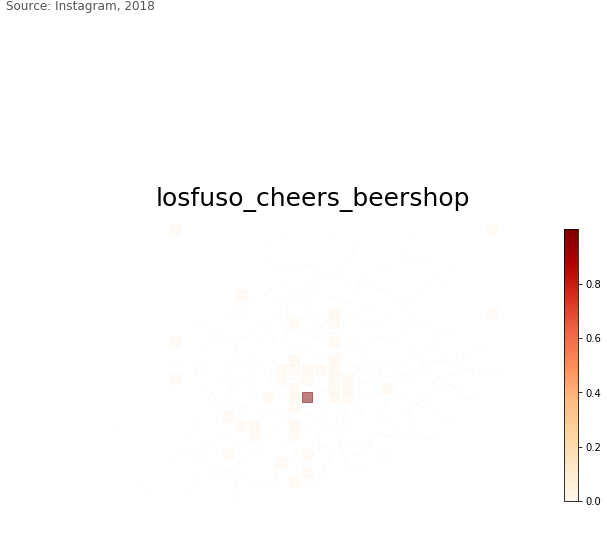

file saved Results/2019-02-15_8_5000_spl_#3/Heatmaps/losfuso_cheers_beershop


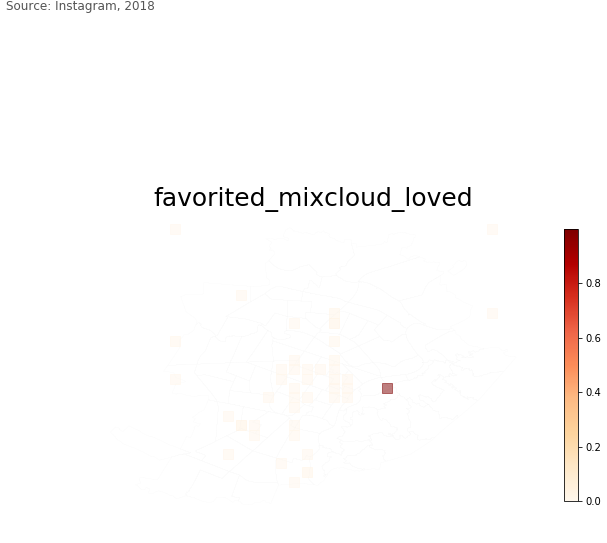

file saved Results/2019-02-15_8_5000_spl_#3/Heatmaps/favorited_mixcloud_loved


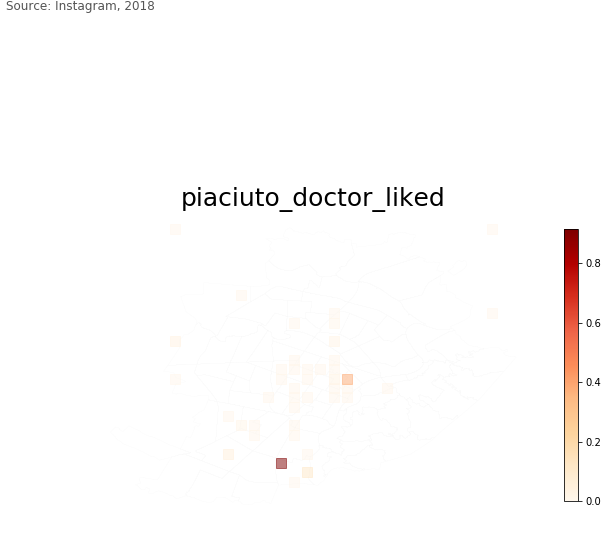

file saved Results/2019-02-15_8_5000_spl_#3/Heatmaps/piaciuto_doctor_liked


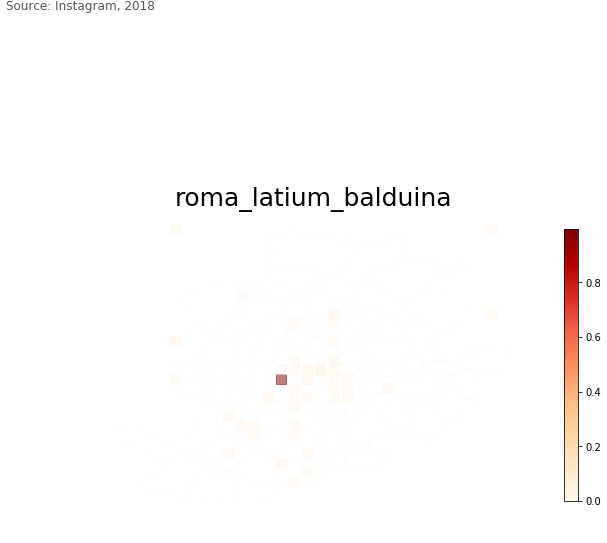

file saved Results/2019-02-15_8_5000_spl_#3/Heatmaps/roma_latium_balduina


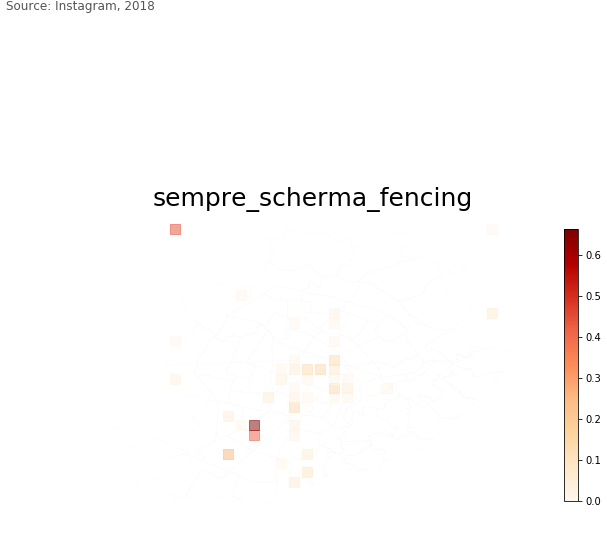

file saved Results/2019-02-15_8_5000_spl_#3/Heatmaps/sempre_scherma_fencing


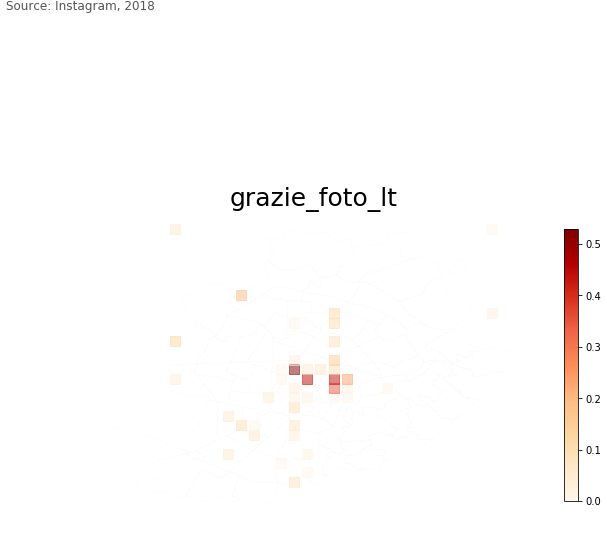

file saved Results/2019-02-15_8_5000_spl_#3/Heatmaps/grazie_foto_lt


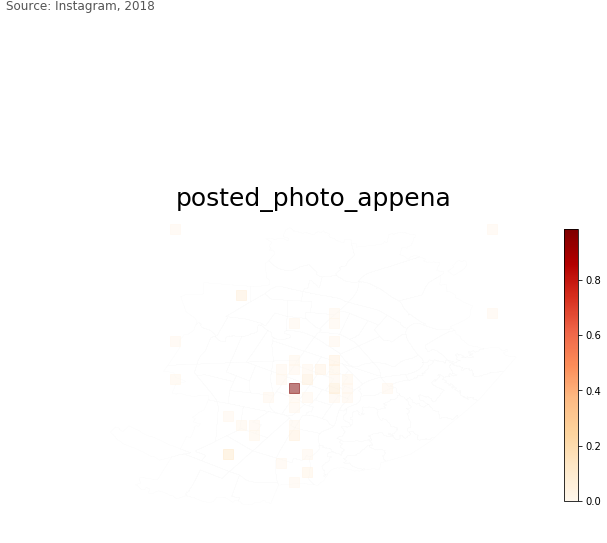

file saved Results/2019-02-15_8_5000_spl_#3/Heatmaps/posted_photo_appena


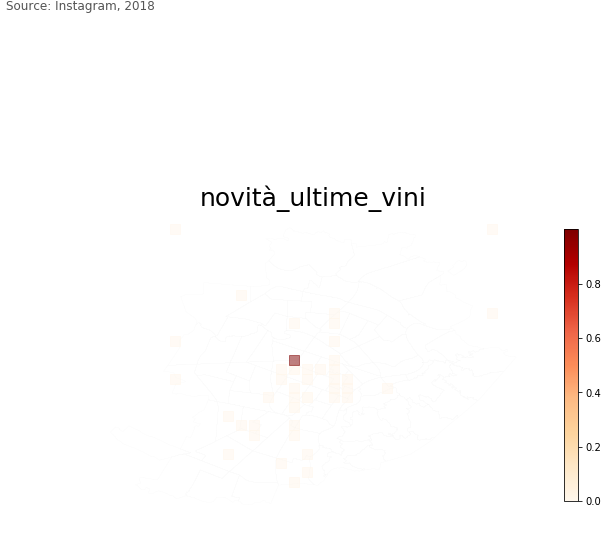

file saved Results/2019-02-15_8_5000_spl_#3/Heatmaps/novità_ultime_vini


/home/eartiges/.local/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


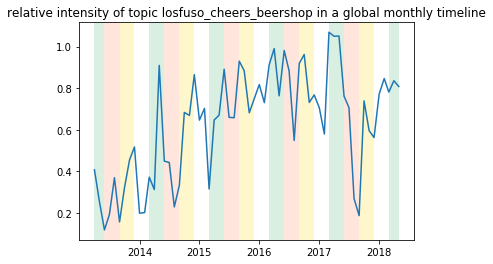

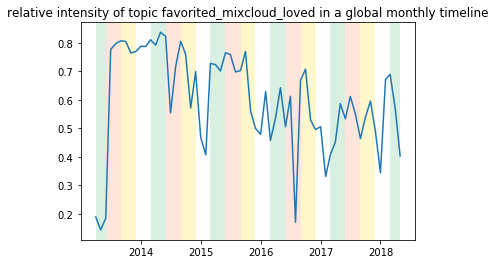

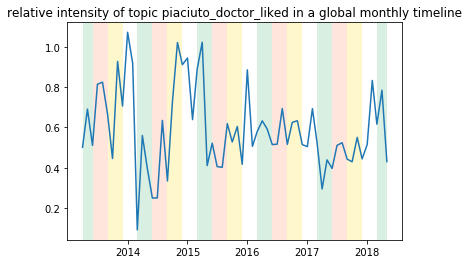

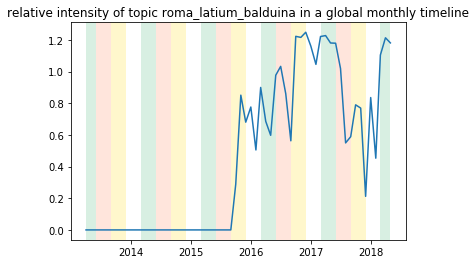

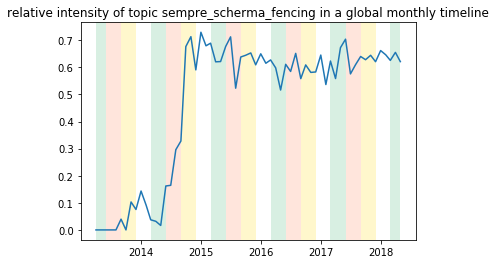

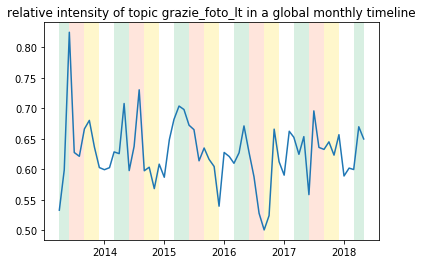

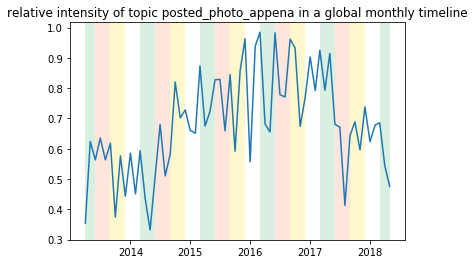

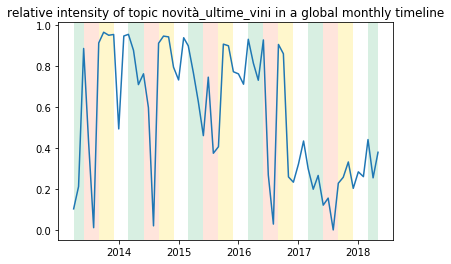

In [49]:
importlib.reload(IL)
importlib.reload(IP)
#msg='Set of Heatmaps made on the 24/01, sampled from April 2013. First run to be made with 17 TV. with Monuments'
#foldername1='Heatmaps_2401_17_spl'
#foldername2='NTF_2401_17_spl'

#Geographical repartition of topics
for i in range(0,len(A.T)):
    Coordinates=list(df_classified.index)
    row=A.T[i]
    topic=''
    for j in (0,1,2):
        topic+='_'+TermVectorsIndex[i][j][0]
    #IL.geo_topic(row,Coordinates,i,topic=topic,save=True,folder=path+'Heatmaps/')
    #IP.geo_hm_one(A.T[i],df_toNTF.index,'OrRd',string.join([t[0] for t in TermVectorsIndex[i][0:3]]),save=True,folder=path+'Heatmaps/',shapefile='zone_statistiche_geo/zone_statistiche_geo.shp')
    IP.geo_plot_one(A.T[i],df_toNTF.index,'OrRd','_'.join([t[0] for t in TermVectorsIndex[i][0:3]]),save=True,folder=path+'Heatmaps/',shapefile='zone_statistiche_geo.shp')

# Time Series    
seasons=['white', 'mediumseagreen', 'coral', 'gold']
for index in range(0, len(C.T)):
    row=C.T[index]
    topic=''
    for i in (0,1,2):
        topic+=TermVectorsIndex[index][i][0]+'_'
    topic=topic.strip('_')
    plt.figure()
    plt.plot(flags[start:][0:len(row)], row)
    plt.xticks(flags[start:stop][[f.date().month for f in flags[start:stop]].index(1)::12])
    for i in range(0, len(flags[start:stop])-1):
        season=seasons[int(((int(str(flags[start+i].date()).split('-')[1])-3)/3+1)%4)]
        plt.axvspan(flags[start+i],flags[start+i+1], facecolor=season, alpha=0.2)
    plt.title('relative intensity of topic '+topic+' in a global monthly timeline')
    if True:
        plt.savefig(path+'t_series/plot_topic_'+topic+'.pdf')
    plt.show()
    
f=open(path+'TermVectors.txt','w')
for tvi in TermVectorsIndex[::-1]:
    f.write(str(TermVectorsIndex.index(tvi))+ ' '+str([t[0] for t in tvi[0:10]])+'\n')
f.close()

pickle.dump(A, open(path+'pickle/A.pkl','wb'))
pickle.dump(B, open(path+'pickle/B.pkl','wb'))
pickle.dump(C, open(path+'pickle/C.pkl','wb'))
pickle.dump(Coordinates, open(path+'pickle/Grid.pkl','wb'))
f = open(path+'pickle/Vocabulary.csv', 'w')
for item in feature_names:
    f.write("%s\n" % item.encode('utf-8'))
f.close()

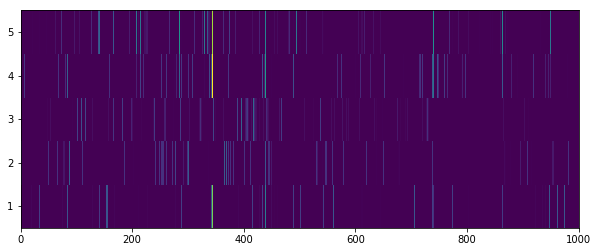

In [109]:
#Topics definition
plt.figure(figsize=(10,4))
plt.pcolormesh(B.T)#, cmap=plt.cm.Greys)
plt.xlim(0,B.shape[0])
plt.yticks(np.arange(B.shape[1])+0.5, np.arange(1,B.shape[1]+1))
#plt.savefig('Topic_definition_normalized.pdf')
plt.show()

#for tvi in TermVectorsIndex:
    #print TermVectorsIndex.index(tvi), [t for t in tvi[0:3]]
#    print TermVectorsIndex.index(tvi), [t[0] for t in tvi[0:5]]

In [ ]:
CommonWords=set([])
for t in TermVectors:
    for t_other in TermVectors:
        if t_other!=t:
            for term in t.union(t_other):
                CommonWords.add(term)

In [ ]:
for t in TermVectors:
    T=list(t)
    print len(t)
    for word in t:
        if word in CommonWords:
            T.remove(word)
    t=set(T)
    print len(T)

In [182]:
for tvi in TermVectorsIndex:
    #print TermVectorsIndex.index(tvi), [t for t in tvi[0:3]]
    print TermVectorsIndex.index(tvi), [t[0].encode('utf-8') for t in tvi[0:10]]

0 ['dar', 'climbing', 'fly', 'winter', 'dark', 'murales', 'solocosebell', 'libr', 'lif', 'song']
1 ['aspett', 'palazz', 'mylif', 'palestr', 'augur', 'facil', 'domen', 'river', 'student', 'training']
2 ['pics', 'archidaily', 'arred', 'shoes', 'class', 'torinocity', 'sunday', 'mylif', 'bas', 'lamor']
3 ['hair', 'collin', 'hairstyl', 'far', 'likebackteam', 'green', 'streetart', 'beauty', 'gir', 'blu']
4 ['torinopics', 'cald', 'complet', 'animal', 'party', 'prefer', 'don', 'citt', 'far', 'camb']
5 ['tagstagram', 'ink', 'tagstagramers', 'inked', 'tor', 'colours', 'sempr', 'tak', 'pres', 'blackandwh']
6 ['piedmont', 'disc', 'cenett', 'happy', 'see', 'amazing', 'famigl', 'yum', 'sunris', 'never']
7 ['nom', 'buongiorn', 'scuol', 'grass', 'music', 'amazing', 'gioi', 'bell', 'prefer', 'grand']
8 ['sunny', 'italian', 'centr', 'portrait', 'grass', 'buongiorn', 'amazing', 'tim', 'color', 'song']
9 ['piogg', 'ricord', 'mountains', 'fitness', 'brutt', 'poc', 'sunday', 'never', 'vinc', 'student']
10 [

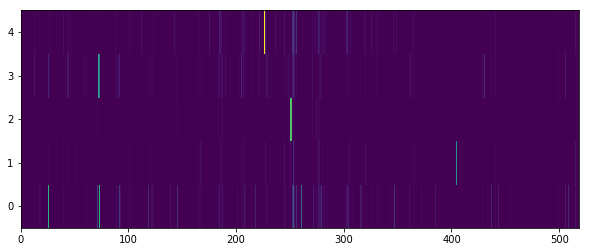

4 [u'fumett', u'comics', u'fumetter', u'nerd', u'epic']
3 [u'cosplay', u'comics', u'cosplayer', u'xmascomics', u'mang']
2 [u'mua', u'makeupartist', u'makeup', u'mbacademy', u'makeuplover']
1 [u'tatto', u'comics', u'ink', u'inked', u'tattooart']
0 [u'cosplay', u'cosplayer', u'comics', u'phot', u'anim']


In [127]:
#Topics by bin
plt.figure(figsize=(10,4))
plt.pcolormesh(A.T)#, cmap=plt.cm.Greys)
plt.xlim(0,A.shape[0])
plt.yticks(np.arange(B.shape[1])+0.5, np.arange(0,B.shape[1]+1))
#plt.savefig('Topic_bybin_normalized.pdf')
plt.show()

for tvi in TermVectorsIndex[::-1]:
    #print TermVectorsIndex.index(tvi), [t for t in tvi[0:3]]
    print TermVectorsIndex.index(tvi), [t[0] for t in tvi[0:5]]

In [352]:
for tvi in TermVectorsIndex[::-1]:
    #print TermVectorsIndex.index(tvi), [t for t in tvi[0:3]]
    print TermVectorsIndex.index(tvi), [t[0] for t in tvi[0:5]]

14 [u'mol', u'night', u'buongiorn', u'immagin', u'murazz']
13 [u'iphones', u'paratissim', u'streetphotography', u'ros', u'light']
12 [u'iphon', u'iphones', u'photography', u'cool', u'th']
11 [u'iphon', u'photography', u'phot', u'night', u'iphones']
10 [u'plac', u'fot', u'phot', u'day', u'drawing']
9 [u'color', u'sky', u'night', u'ciel', u'po']
8 [u'iphones', u'streetphotography', u'paratissim', u'snow', u'iphon']
7 [u'rain', u'buon', u'brav', u'port', u'amic']
6 [u'iphones', u'piazz', u'bell', u'sky', u'street']
5 [u'iphon', u'night', u'animal', u'churc', u'yellow']
4 [u'sush', u'dolc', u'cas', u'ris', u'old']
3 [u'san', u'streetphotography', u'luc', u'light', u'sunris']
2 [u'sky', u'winter', u'ciel', u'cas', u'sunset']
1 [u'sott', u'adess', u'mett', u'far', u'andar']
0 [u'snow', u'nev', u'tre', u'winter', u'rom']


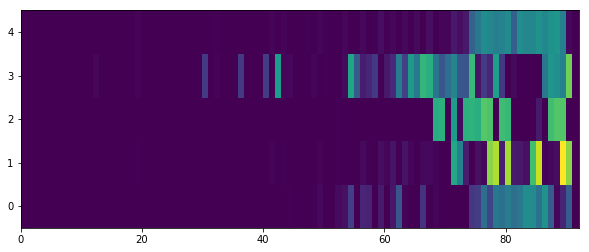

4 [u'fumett', u'comics', u'fumetter', u'nerd', u'epic', u'comicbook']
3 [u'cosplay', u'comics', u'cosplayer', u'xmascomics', u'mang', u'anim']
2 [u'mua', u'makeupartist', u'makeup', u'mbacademy', u'makeuplover', u'makeupaddict']
1 [u'tatto', u'comics', u'ink', u'inked', u'tattooart', u'tattooartist']
0 [u'cosplay', u'cosplayer', u'comics', u'phot', u'anim', u'xmascomics']


In [125]:
#Topics Dynamics
plt.figure(figsize=(10,4))
plt.pcolormesh([c for c in C.T])#, cmap=plt.cm.Greys)
plt.xlim(0,len(C.T[0]))
#plt.savefig('Topic_dynamic.pdf')
plt.yticks(np.arange(n_topics)+0.5, np.arange(0,n_topics));
#plt.xticks(flags[start:stop])
plt.show()
for tvi in TermVectorsIndex[::-1]:
    #print TermVectorsIndex.index(tvi), [t for t in tvi[0:3]]
    print TermVectorsIndex.index(tvi), [t[0] for t in tvi[0:6]]

In [65]:
foldername='Word2vec_TFF'
if foldername not in os.listdir('PKL_files/results/'):
    os.mkdir('PKL_files/results/'+foldername)
foldername='PKL_files/results/'+foldername
pickle.dump(A, open(foldername+'/A.pkl','wb'))
pickle.dump(B, open(foldername+'/B.pkl','wb'))
pickle.dump(C, open(foldername+'/C.pkl','wb'))
pickle.dump(Coordinates, open(foldername+'/Grid.pkl','wb'))
f = open(foldername+'/Tortest_inst_spl.csv', 'w')
for item in feature_names:
    f.write("%s\n" % item.encode('utf-8'))
f.close()

In [148]:
seasons

['white', 'green', 'red', 'orange']

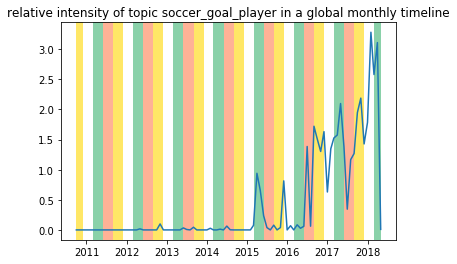

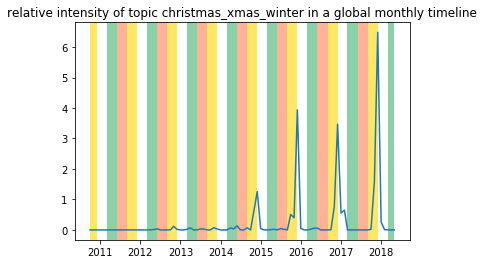

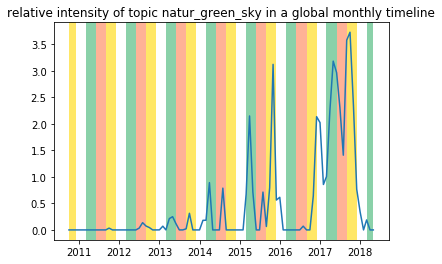

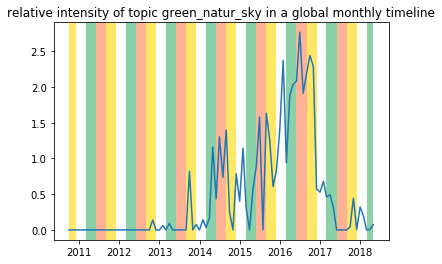

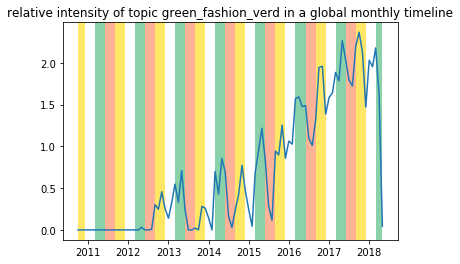

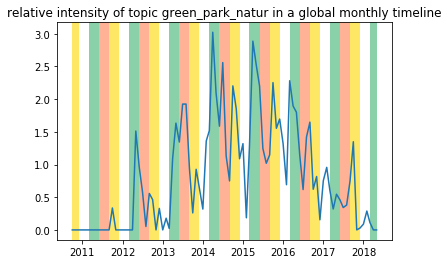

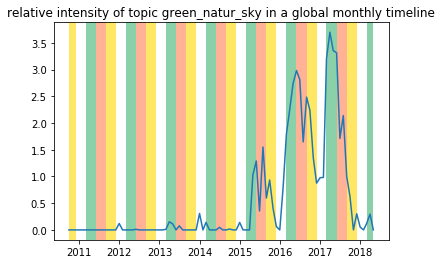

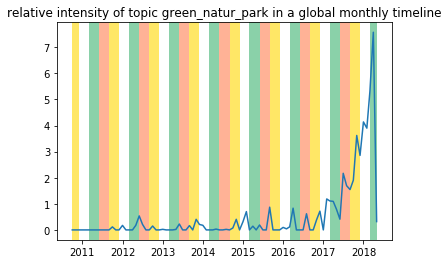

In [156]:
#foldername='Heatmaps_2401_17_noMon'
for index in range(0, len(C.T)):
    row=C.T[index]
    topic=''
    for i in (0,1,2):
        topic+=TermVectorsIndex[index][i][0]+'_'
    topic=topic.strip('_')
    plt.figure()
    plt.plot(flags[start:][0:len(row)], row)
    plt.xticks(flags[start:stop][3::12])
    plt.title('relative intensity of topic '+topic+' in a global monthly timeline')
    for i in xrange(len(flags[start:stop])-1):
        season=seasons[((int(str(flags[start+i].date()).split('-')[1])-3)/3+1)%4]
        plt.axvspan(flags[i],flags[i+1], facecolor=season, alpha=0.6)
        
    if False:
        if foldername not in os.listdir('Figures/Heatmaps/'):
            os.mkdir('Figures/Heatmaps/'+foldername)
        plt.savefig('Figures/Heatmaps/'+foldername+'/plot_topic_'+topic+'.pdf')
    plt.show()

In [ ]:
dfa = pd.DataFrame(A).groupby(voc_serie).sum()
#dfa = dfa[dfa.index!='teachers']

In [ ]:
dfa

In [ ]:
plt.figure(figsize=(10,4))
plt.pcolormesh(C.T)#, cmap=plt.cm.Greys)
plt.xlim(0,C.shape[0])
plt.yticks(np.arange(14)+0.5, np.arange(1,15));

In [ ]:
import scipy.io
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.io import savemat
n_features=1000
n_topics=10

list_reviews_all=df_new['text'].tolist()
counts = vectorizer_s.fit_transform(list_reviews_all)
vectorizer_new = CountVectorizer(max_df=0.95, max_features=n_features,stop_words=all_stopwords_add,vocabulary=vectorizer_s.vocabulary_)
ct=0

# For each month in the dataset, get a snapshot view of the NMF tensor:
for month in range(1,(len(list_years)-1)*12+2,3):
    
    year_start=list_years[0]+ int(month/12)
    month_start=month%12  
    year_end=list_years[0]+ int(month+11-0.5)/12
    month_end=1+(month+11-1)%12
    
    try:
        list_reviews_rest=dataframe_collection[str(year_start) + '-' + str(month_start)]['text'].tolist()
    except KeyError:
        continue
        
    # Learn the vocabulary dictionary and return term-document matrix.
    counts = vectorizer_new.fit_transform(list_reviews_rest)
    
    #Transform a count matrix to a normalized tf-idf representation. 
    #(mainly =Terms with frequencies too hi or lo are removed)
    tfidf = TfidfTransformer().fit_transform(counts)
    
    #Save the data in matlab friendly format
    savemat('Inst500Matr' + str(ct), {'tfidf':tfidf})
    
    
    nmf = decomposition.NMF(n_components=n_topics)
    
    #We are looking for two matrices whose product approximates tfidf.
    
    # Learn the model (parameters etc.). I.e "take a look at what we have". returns nothing.
    W = nmf.fit(tfidf)
    
    # dictionary (factorization matrix)
    H = nmf.components_
    
    # Extracts the data and performs NMF on the tfidf-treated dataset. 
    # Returns the matrix W (the weight matrix), to be multiplied by the matrix H (dictionary) to get target tfidf.
    X2 = nmf.fit_transform(tfidf)
    ct=ct+1
    feature_names = vectorizer_new.get_feature_names()
    print month
    for i,text_topic in enumerate(X2.T):
        
        # i.e -> i, [content of column i of X2]
        # i-th topic named text_topic
        # Why sort them backwards?
        text_top = text_topic.argsort()[:-21:-1]
        word_top = nmf.components_[i].argsort()[:-11:-1]
        
        # For each text topic in the NMF resulting list, print the weight vector and the term vector.
        print [nmf.components_[i,k] for k in nmf.components_[i].argsort()[:-11:-1]]
        print [", ".join([feature_names[i] for i in word_top])]
        
        # print the amount of non-zero components in the weight vector
        l=[text_topic[i] for i in text_top]
        print np.count_nonzero(l)
            

In [ ]:
>>> import numpy as np
>>> X = np.array([[1, 1], [2, 1], [3, 1.2], [4, 1], [5, 0.8], [6, 1]])
>>> from sklearn.decomposition import NMF
>>> model = NMF(n_components=2, init='random', random_state=0)
>>> W = model.fit_transform(X)
>>> H = model.components_

In [ ]:
X

In [ ]:
for i, t in enumerate(X):
    print i,t

In [ ]:
print feature_names

In [ ]:
#save the feature names in a csv file
type(feature_names)
import io

f = io.open('test_inst_Torino.csv', 'w', encoding='utf8')
for item in feature_names:
    print item
    f.write("%s\n" % item)

In [ ]:
#Boundaries of the map
print (df_new['lonbin'].min()-step_lon/2., df_new['latbin'].min()-step_lat/2., df_new['lonbin'].max()+step_lon/2., df_new['latbin'].max()+step_lat/2)

In [ ]:
len(df_new_nodup_cells['n'].unique())
list_rc=df_new_nodup2_cells['n'].tolist()
with open('n_inst500.txt', 'w') as fp:
    fp.write('\n'.join('%s' % x for x in list_rc))

In [ ]:
list_rc

In [ ]:
df_new_nodup2_cells

In [ ]:
df_new_nodup2_cells.head()

In [ ]:
import time
import datetime
list_time=[]
for month in range(1,(len(list_years)-1)*12+2,3):
        year_start=list_years[0]+ int(month/12)
        month_start=month%12  
        year_end=list_years[0]+ int(month+11-0.5)/12
        month_end=1+(month+5-1)%12
             
     
        if month_end in([2,4,6,9,11]):
            day=30
        else:
            day=31
        deb=str(year_start) + '-' + str(month_end) + '-1'
        deb_new=time.mktime(datetime.datetime.strptime(deb, "%Y-%m-%d").timetuple())
        if month==1:
            list_time= np.append(deb_new,list_time)
        else:
            list_time=np.append(list_time,deb_new)


In [ ]:
print list_time

In [143]:
from sklearn.feature_extraction.text import CountVectorizer

In [150]:
vectorizer = CountVectorizer()
corpus = ['This is the first document.',
     'This is the second second document.',
     'And the third one.',
          '',
          '',
     'Is this the first document?']
X_vec = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names()
X_vec.toarray()      
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
X_fidf = transformer.fit_transform(X_vec.toarray())
print X_fidf.toarray()

[[0.         0.43746414 0.54222553 0.43746414 0.         0.
  0.36313476 0.         0.43746414]
 [0.         0.26203538 0.         0.26203538 0.         0.86411832
  0.21751303 0.         0.26203538]
 [0.55440642 0.         0.         0.         0.55440642 0.
  0.27910674 0.55440642 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.43746414 0.54222553 0.43746414 0.         0.
  0.36313476 0.         0.43746414]]


In [ ]:

with open('times_inst500.txt', 'w') as fp:
    fp.write('\n'.join('%s' % x for x in list_time))

In [ ]:
Text_tot=[]

if sampling:
    for month in snapshots[start:stop]:
        Text=df_classified[month].tolist()
        #Split the posts: how many of them do we have in each bin?
        list_reviews_rest = [len(a.split(',')) for a in Text]
        #Which bins have info?
        list_indices_info=[Text.index(a) for a in Text if a!='']
        #If we have more posts this month than in the reference month
        if threshold<len(list_reviews_rest):
            #On a bin with info...
            choices=[np.random.choice(list_indices_info) for i in xrange(threshold)]
            #...Pick a tweet among those there.
            choices =[(e,np.random.randint(0,list_reviews_rest[e])) for e in choices]
            This_Month=['' for i in Text]
            for tweet in choices:
                This_Month[tweet[0]]+=Text[tweet[0]].split(',')[tweet[1]]+','
            Text_tot.append(This_Month)
        else:
            Text_tot.append(Text)
            
for month in snapshots[start:stop]:
    ct+=1
    print flags[snapshots.index(month)]
    try:
        if sampling:
            This_Month=Text_tot
        else:
            This_Month=df_classified[month].tolist()

In [98]:
import geopandas

In [101]:
df = geopandas.read_file(geopandas.datasets.get_path('tobb'))
ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

ValueError: The dataset 'tobb' is not available

In [103]:
cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))

In [112]:
geopandas.datasets.available

['naturalearth_lowres', 'naturalearth_cities', 'nybb']

In [111]:
'Lyon' in cities.name.tolist()

False